In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy import stats

### Задание 1
<b>Retention</b> – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).


In [3]:
reg_df = pd.read_csv('~/shared/problem1-reg_data.csv', encoding = 'windows-1251', sep = ';')
reg_df

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [4]:
auth_df = pd.read_csv('~/shared/problem1-auth_data.csv', encoding = 'windows-1251', sep = ';')
auth_df

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [5]:
reg_df['reg_ts'] = pd.to_datetime(pd.to_datetime(reg_df['reg_ts'], unit='s').dt.date)
auth_df['auth_ts'] = pd.to_datetime(pd.to_datetime(auth_df['auth_ts'], unit='s').dt.date)

In [6]:
# Проверка на пропущенные значения
print(reg_df.isnull().sum()) 
print(auth_df.isnull().sum()) 

# Расчет статистических показателей и построение гистограммы распределения
print(reg_df.describe())
print(auth_df.describe())

# Проверка на повторяющиеся значения
print(reg_df.duplicated().sum())
print(auth_df.duplicated().sum())

reg_ts    0
uid       0
dtype: int64
auth_ts    0
uid        0
dtype: int64
                uid
count  1.000000e+06
mean   5.552354e+05
std    3.206011e+05
min    1.000000e+00
25%    2.776438e+05
50%    5.550455e+05
75%    8.329712e+05
max    1.110622e+06
                uid
count  9.601013e+06
mean   3.347198e+05
std    2.832669e+05
min    1.000000e+00
25%    9.599700e+04
50%    2.579210e+05
75%    5.190250e+05
max    1.110622e+06
0
0


In [7]:
# Тип данных в колонках
reg_df.dtypes
auth_df.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [8]:
start_date = '2020-08-01'
end_date = '2020-08-31'

In [9]:
# Функция по расчитыванитю retention
def calculate_retention(reg_df, auth_df, start_date, end_date):
    reg_df = reg_df.query("reg_ts >= @start_date")
    auth_df = auth_df.query("auth_ts <= @end_date")
    merged_df = pd.merge(reg_df, auth_df, on='uid', how='inner')
    merged_df['diff_days'] = (merged_df['auth_ts'] - merged_df['reg_ts']).dt.days
    merged_df = merged_df.groupby(['reg_ts', 'diff_days'], as_index=False)\
                            .agg({'uid': 'nunique'})\
                            .pivot(index='reg_ts', columns='diff_days', values='uid')
    retention_df = merged_df.divide(merged_df.iloc[:, 0], axis = 0)
    retention_df = retention_df.drop(retention_df.columns[0], axis = 1)  
    sns.set(style='ticks', rc={"figure.figsize": (25, 15)}) 
    sns.heatmap(data=retention_df, annot=True,  fmt='.0%', cmap='Blues', cbar = False, linewidth=.01, vmin=0, vmax=0.1)
    plt.title('retention')
    plt.ylabel('reg_date')
    plt.xlabel('days')
    plt.show()
    return plt.show()

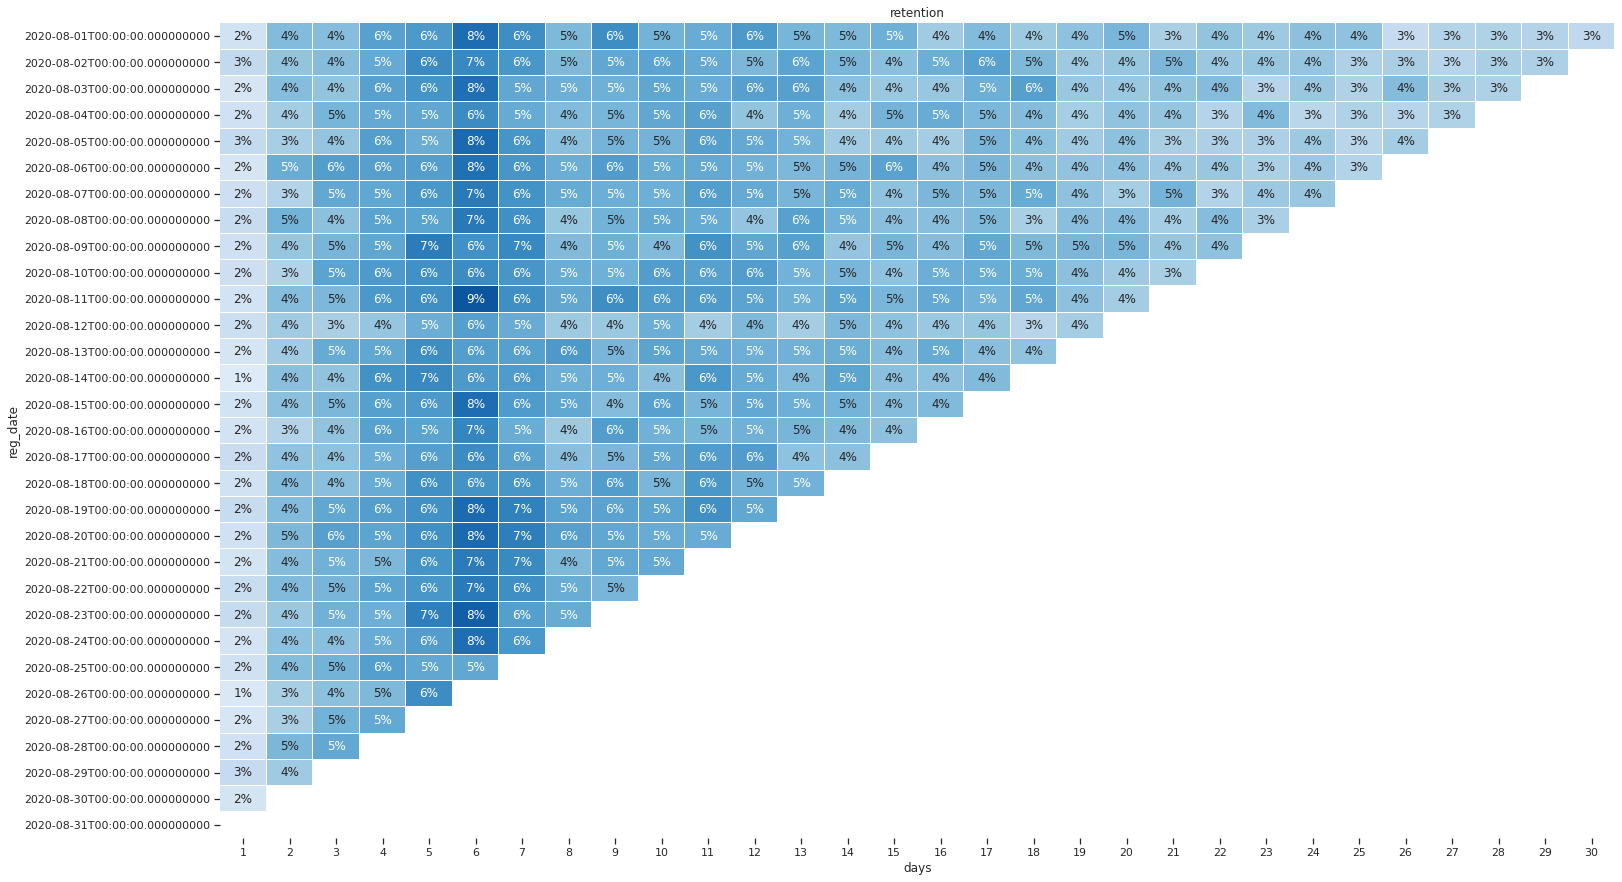

In [10]:
calculate_retention(reg_df, auth_df, start_date, end_date)

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [11]:
ab = pd.read_csv('~/final_project/Проект_1_Задание_2.csv', encoding = 'windows-1251', sep = ';')

In [12]:
ab

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [13]:
ab.isna().sum()
ab.describe()
ab.dtypes

user_id      0
revenue      0
testgroup    0
dtype: int64

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


user_id       int64
revenue       int64
testgroup    object
dtype: object

In [14]:
#  Разобьем дф на два (тестовую и контрольную)
test_group = ab[ab['testgroup'] =='b']
control_group = ab[ab['testgroup'] =='a']
test_group
control_group

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [15]:
arppu_test_group = test_group[test_group['revenue'] > 0]
arppu_control_group = control_group[control_group['revenue'] > 0]
arppu_test_group
arppu_control_group

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b
...,...,...,...
403843,403844,3383,b
403994,403995,2793,b
404161,404162,2316,b
404193,404194,2998,b


,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


In [16]:
# Средняя выручка на пользователя
arpu_test = test_group['revenue'].sum() / test_group['user_id'].nunique()
arpu_control = control_group['revenue'].sum() / control_group['user_id'].nunique()

# Cредний доход с платящего пользователя
arppu_test = arppu_test_group.shape[0]
arppu_control = arppu_control_group.shape[0]

# Конверсия в платежи
conversion_test = test_group[test_group['revenue'] > 0]['user_id'].nunique() / test_group['user_id'].nunique()
conversion_control = control_group[control_group['revenue'] > 0]['user_id'].nunique() / control_group['user_id'].nunique()


In [17]:
print ("Средняя выручка на пользователя в тестовой группе:", arpu_test)
print ("Средняя выручка на пользователя в контрольной группе:", arpu_control)
print ("Cредний доход с платящего пользователя в тестовой группе:", arppu_test)
print ("Cредний доход с платящего пользователя в контрольной группе:", arppu_control)
print ("Конверсия в платежи в тестовой группе:", conversion_test)
print ("Конверсия в платежи в контрольной группе:", conversion_control)

Средняя выручка на пользователя в тестовой группе: 26.75128659327863
Средняя выручка на пользователя в контрольной группе: 25.413719736965806
Cредний доход с платящего пользователя в тестовой группе: 1805
Cредний доход с платящего пользователя в контрольной группе: 1928
Конверсия в платежи в тестовой группе: 0.008906235351586593
Конверсия в платежи в контрольной группе: 0.009539690157988749


 
 
 Проведем тесты и выясним есть ли <b>статистически значимые</b> различия в метриках между группами. Для этого сначала проверим данные на нормальность и гомогенность.
 

In [18]:
pg.normality(data = test_group, dv = "revenue", group = "testgroup", method = "normaltest")
pg.normality(data = control_group, dv = "revenue", group = "testgroup", method = "normaltest")

,W,pval,normal
b,326622.395409,0.0,False


,W,pval,normal
a,585152.731273,0.0,False


По результатам теста мы видим, что в обеих группах <b>p-value < 0.05 </b> это говорит о том, что данные распределены <b>ненормально</b>.

In [19]:
pg.homoscedasticity(data = ab, dv = "revenue", group = "testgroup") 

,W,pval,equal_var
levene,0.389629,0.532495,True


Гомогенность данных у нас в порядке. Здесь применим T-тест, потому что данные у нас гомогенны, а из-за больших выборок отсутвием нормальности в распределение данных можно пренебречь. Тестируем стат.значимость изменений метрик по доходам - ARPU и ARPPU



### Сформулируем гипотезы:

####     Н0 - нет статистически значимых различий между контрольной и тестовой групп
####      Н1 - есть статистически значимые различия между контрольной и тестовой групп

In [20]:
arpu_ttest = pg.ttest(test_group.revenue, 
          control_group.revenue)
arppu_ttest = pg.ttest(arppu_test_group.revenue, 
          arppu_control_group.revenue)
arpu_ttest
arppu_ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.623488,240991.130782,two-sided,0.532965,"[-2.87, 5.54]",0.001962,0.004,0.095694


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.64463,1943.481522,two-sided,0.100208,"[-65.38, 744.7]",0.052132,0.142,0.356381


Поскольку p-значение больше 0,05 в обоих случаях, мы <b>отклонить Н0 гипотезу не можем</b> и делаем вывод, что <b>статистически значимых различий</b> между ARPU и ARPPU контрольной и тестовой групп <b>нет</b>. 

Осталось проверить влияние различных наборов акционных предложений на CR и есть ли статистически значимые различия между группами. Для проверки подойдет критерий Хи-квадрат, так как сравниваются категориальные данные.

In [21]:
ab['conversion'] = ab['revenue'].apply(lambda x: 1 if x > 0 else 0)
ab

,user_id,revenue,testgroup,conversion
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [22]:
stat, p, dof, expected = stats.chi2_contingency(pd.crosstab(ab.testgroup, ab.conversion))
p

0.03647561892312613

 В результате у нас получилось <b>p-значение < 0.05</b>, <b>мы отклоняем H0</b> и делаем вывод, что набор акционных предложений влияет на показатель CR.

### ВЫВОД:

Провели исследования в контрольной и тестовой группах таких метрик как ARPU, ARPPU, CR. При анализе метрик ARPU, ARPPU статистически значимых различий между группами не обнаружилось. В CR были видны статистически значимые различия между группами, но мы не можем дать точный ответ на вопрос <i>"Какие наборы предложений были лучше?"</i>.

### Задание 3
В игре <b>Plants & Gardens </b> каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Метрики


- Количество участников события - это показатель, который позволяет оценить интерес игроков к ограниченому тематическому событию. Чем больше участников, тем более успешным можно считать событие. Для расчета требуется посчитать количество игроков, зарегистрировавшихся на событие.


- Среднее количество завершенных уровней - это показатель, который показывает сколько уровней было пройдено игроками. Чем больше уровней было завершено, тем более успешным можно считать событие. Для расчета требуется посчитать среднее количество пройденных уровней на каждого игрока.


- Среднее время прохождения уровня. Эта метрика показывает, сколько времени в среднем требуется игрокам для прохождения каждого уровня. Если время прохождения сильно отличается от обычных уровней в игре, это может указывать на то, что уровни были слишком сложными или наоборот, слишком легкими. Расчет осуществляется путем высчитвания среднего времени прохождения уровня на каждого игрока.




#### Для другого события расчитаем новые метрики, которые так же покажут возможное увеличения сложности, тем самым увеличением оттока игроков




- Количество неудачных попыток выполнения уровня - показывает, насколько сложными были уровни и насколько часто игроки терпели неудачи. Расчет осуществляется путем подсчета общего количества неудачных попыток выполнения уровней на каждого игрока.


- Количество игроков, которые прекратили участие в событии после нескольких неудачных попыток выполнения уровня - показывает, насколько сложными были уровни и насколько игроки были мотивированы продолжать участие в событии. Для расчета данной метрики потребуется посчитать количество игроков, которые прекратили участие в событие и сопоставить с количеством неудачных попыток для каждого игрока, который перестал участвовать в событии.